In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('../src')
from lda import GibbsLDA
from sim import make_dataset
from utils import show_dataset

In [ ]:
from torch import nn, optim

NORM = {'batch': nn.BatchNorm1d, 'layer': nn.LayerNorm}
ACT = {'relu': nn.ReLU, 'prelu': nn.PReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh, 'softplus': nn.Softplus}
OPTIM = {'adam': optim.Adam, 'sgd': optim.SGD}

class MLP(nn.Sequential):
    def __init__(self, *channels, bias=True, norm_layer=None, act_layer=None, dropout=0., final_bias=True, final_norm=None, final_act=None, final_dropout=0.):
        modules = []

        for i in range(1, len(channels) - 1):
            modules.append(self.layer(channels[i - 1], channels[i], bias, norm_layer, act_layer, dropout))

        modules.append(self.layer(channels[-2%len(channels)], channels[-1], final_bias, final_norm, final_act, final_dropout))

        super().__init__(*modules)

    @staticmethod
    def layer(in_channels, out_channels=None, bias=True, norm_layer=None, act_layer=None, dropout=0.):
        if out_channels is None:
            out_channels = in_channels

        module = nn.Sequential(nn.Linear(in_channels, out_channels, bias))

        if norm_layer is not None:
            module.append(NORM[norm_layer](out_channels))

        if act_layer is not None:
            module.append(ACT[act_layer]())

        if dropout > 0.:
            module.append(nn.Dropout(dropout))

        return module

In [3]:
import torch
from base import buildmethod

class Encoder(nn.Module):
    def __init__(self, in_channels, wc_channels=(128, 128), bc_channels=(128, 128), lp_channels=(128, 128), act_layer='prelu'):
        super().__init__()

        self.in_channels = in_channels
        self.wc_channels = (wc_channels,) if isinstance(wc_channels, int) else wc_channels
        self.bc_channels = (bc_channels,) if isinstance(bc_channels, int) else bc_channels
        self.lp_channels = (lp_channels,) if isinstance(lp_channels, int) else lp_channels
        self.lp_channels += (1,)*(self.lp_channels[-1] != 1)
        self.act_layer = act_layer

        self._wc_model = MLP(self.in_channels, *self.wc_channels, act_layer=self.act_layer)
        self._us_model = MLP(self.in_channels, *self.wc_channels, act_layer=self.act_layer)
        self._bc_model = MLP(self.wc_channels[-1], *self.bc_channels, act_layer=self.act_layer)
        self._lp_model = MLP(self.wc_channels[-1] + self.bc_channels[-1], *self.lp_channels, act_layer=self.act_layer, final_bias=False)

    def _build(self, X):
        self._batch_size = X.shape[0] if X.ndim > 2 else 1
        self._n_samples, self._n_topics = X.shape[-2], 1
        self._wc, self._us = self._wc_model(X), self._us_model(X)
        self._WC = torch.zeros((self._batch_size, 1, self.wc_channels[-1]))
        self._WC[:, 0], self._US = self._wc[:, 0], self._us[:, 2:].sum(1)

        return self
    
    def _update(self, idx, topics):
        n_topics = topics[:idx].unique().shape[0]

        if n_topics == self._n_topics:
            self._WC[:, topics[idx - 1]] += self._wc[:, idx - 1]
        else:
            self._WC = torch.cat((self._WC, self._wc[:, idx - 1].unsqueeze(1)), 1)

        if idx == self._n_samples - 1:
            self._US = torch.zeros((self._batch_size, self.wc_channels[-1]))
        else:
            self._US -= self._us[:, idx]

        self._n_topics = n_topics

        return n_topics
    
    def _logprobs(self, idx):
        US_k = self._US.repeat(self._n_topics, 1, 1)
        WC_k = self._WC.repeat(self._n_topics, 1, 1, 1)
        topic_range = torch.arange(self._n_topics)
        WC_k[topic_range, :, topic_range] += self._wc[:, idx]
        WC_K = torch.cat((self._WC, self._wc[:, idx].unsqueeze(1)), 1)
        BC_k, BC_K = self._bc_model(WC_k).sum(2), self._bc_model(WC_K).sum(1)
        logprobs = torch.zeros((self._batch_size, self._n_topics + 1))
        logprobs[:, :-1] = self._lp_model(torch.cat((US_k, BC_k), -1))[..., 0].T
        logprobs[:, -1] = self._lp_model(torch.cat((self._US, BC_K), 1)).squeeze()
        m, _ = logprobs.max(1, keepdim=True)
        logprobs = logprobs - m - (logprobs - m).exp().sum(1, keepdim=True).log()

        return logprobs
    
    @buildmethod
    def evaluate(self, X, y):
        nll = 0

        for i in range(2, self._n_samples):
            self._update(i, y)
            logprobs = self._logprobs(i)
            nll -= logprobs[:, y[i]].mean()

        return nll
    
    @buildmethod
    def forward(self, X):
        z = torch.zeros(X.shape[-2], dtype=torch.int32)

        for i in range(2, self._n_samples):
            self._update(i, z)
            probs = self._logprobs(i).exp()
            z[i] = torch.mode(torch.multinomial(probs, 1).squeeze()).values.item()

        return z

In [25]:
from base import HotTopic
from utils import shuffle

class NCP(HotTopic, nn.Module):
    def __init__(self, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), act_layer='prelu', optim='adam', desc='NCP'):
        super().__init__(desc, check=False)

        self.wc_channels = wc_channels
        self.bc_channels = bc_channels
        self.lp_channels = lp_channels
        self.act_layer = act_layer
        self.optim = optim

    def _build(self, X, learning_rate=1e-4, weight_decay=1e-2, batch_size=16):
        self._encoder = Encoder(X.shape[-1], self.wc_channels, self.bc_channels, self.lp_channels, self.act_layer)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self._batch_size = X.shape[0] if X.ndim > 2 and X.shape[0] > batch_size else batch_size

        return self
    
    def _step(self, X, y, n_perms=6, batch_size=16, n_samples=64):
        mask, nll = torch.randperm(X.shape[0])[:batch_size], 0

        for _ in range(n_perms):
            data, labels = shuffle(X[mask], y, sort=True, cut=n_samples)
            perm_nll = self._encoder.evaluate(data, labels)
            perm_nll.backward()
            nll += perm_nll.item()

        self._optim.step()
        self._optim.zero_grad()

        return nll
    
    def _predict(self, X):
        if X.ndim < 3 or X.shape[0] == 1:
            X = X.repeat(self._batch_size, 1, 1)

        topics = self._encoder(X)

        return topics
    
    def forward(self, X):
        topics = self._predict(X)

        return topics

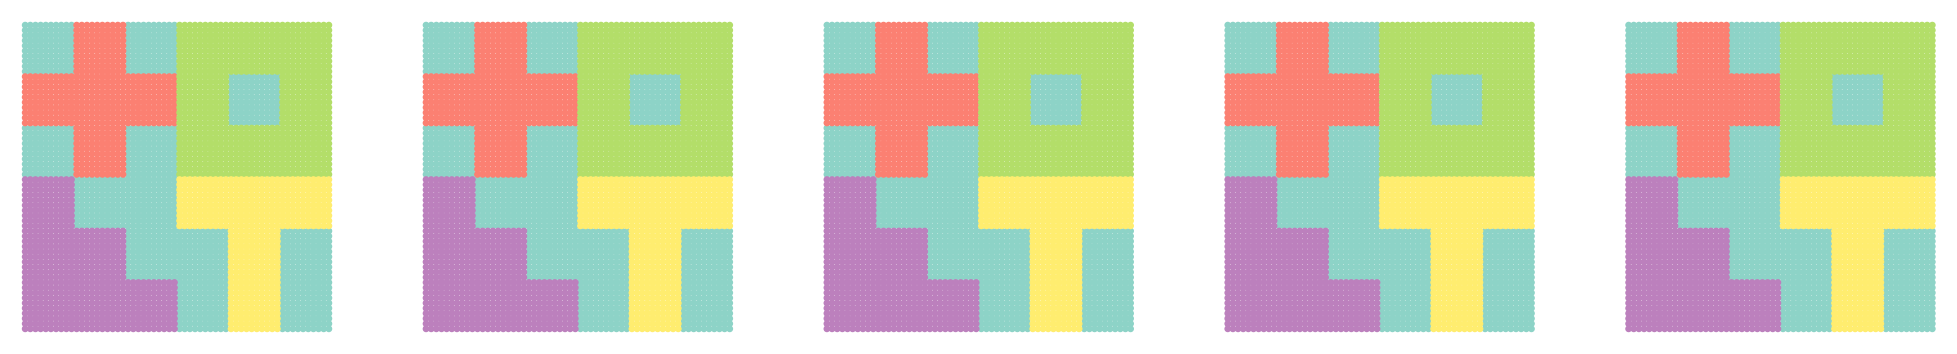

In [26]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*N_DATASETS
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

NCP: 100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


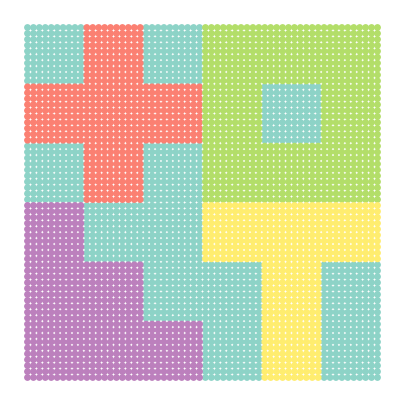

In [27]:
model = NCP()
topics = model.fit(X, y, n_steps=200)(z_features)
show_dataset(z_locations, topics)

In [28]:
from ncp import NCP as oldNCP

NCP: 100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


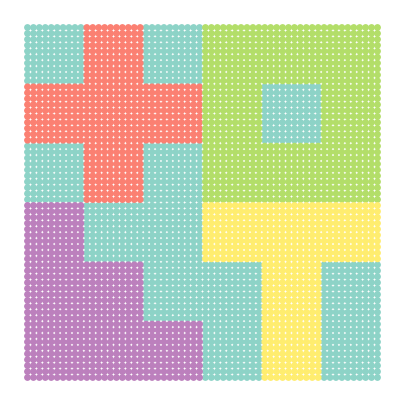

In [29]:
model_old = oldNCP()
topics = model_old.fit(X, y)(z_features)
show_dataset(z_locations, topics)

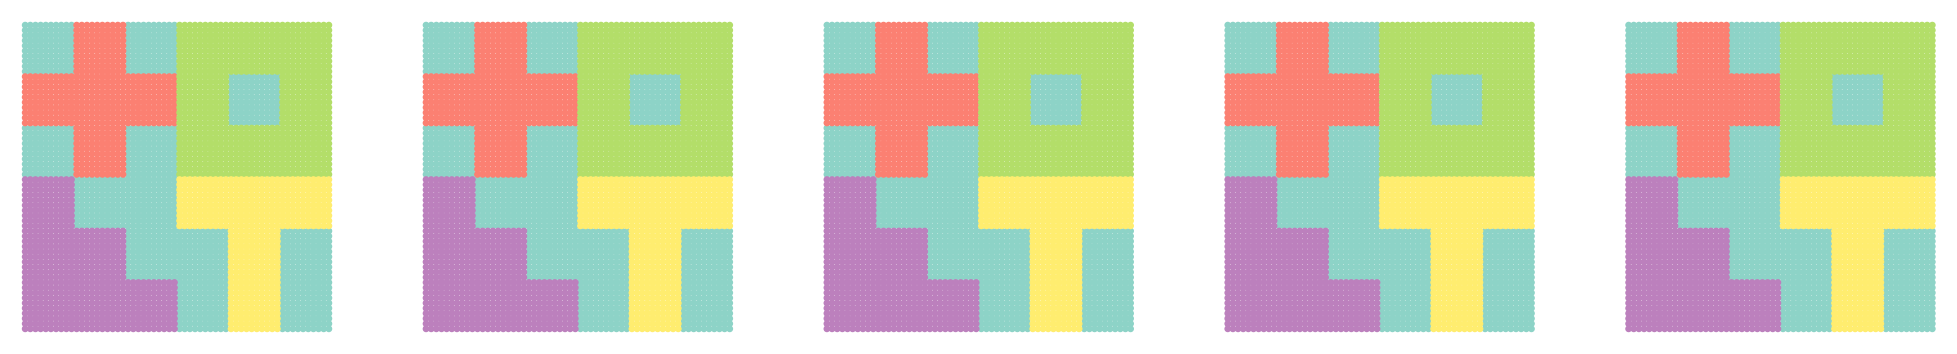

In [33]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*N_DATASETS
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

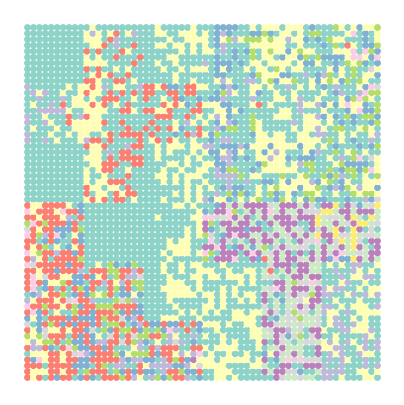

In [34]:
show_dataset(z_locations, model(z_features))

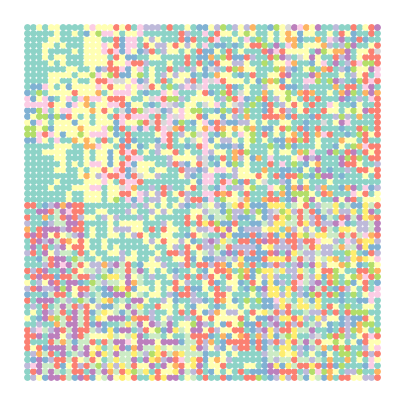

In [35]:
show_dataset(z_locations, model_old(z_features))

In [342]:
import torch
from functools import cache, singledispatch
from torch import nn
from base import buildmethod, HotTopic
from nets import OPTIM, MLP
from utils import shuffle

@cache
def arange(n, step=1, return_tensor=False, **kwargs):
    if return_tensor:
        n_range = torch.arange(0, n, step, **kwargs)
    else:
        n_range = np.arange(0, n, step, **kwargs)
      
    return n_range

@singledispatch
def lognorm(logprobs):
    m, _ = logprobs.max(-1, keepdims=True)
    logprobs = logprobs - m - np.log(np.sum(np.exp(logprobs - m), -1, keepdims=True))

    return logprobs

@lognorm.register(torch.Tensor)
def _(logprobs):
    m, _ = logprobs.max(-1, keepdim=True)
    logprobs = logprobs - m - (logprobs - m).exp().sum(1, keepdim=True).log()

    return logprobs

class Encoder(nn.Module):
    def __init__(self, in_channels, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), act_layer='prelu'):
        super().__init__()

        self.in_channels = in_channels
        self.wc_channels = (wc_channels,) if isinstance(wc_channels, int) else wc_channels
        self.bc_channels = (bc_channels,) if isinstance(bc_channels, int) else bc_channels
        self.lp_channels = (lp_channels,) if isinstance(lp_channels, int) else lp_channels
        self.lp_channels += (1,)*(self.lp_channels[-1] != 1)

        self._wc_model = MLP(self.in_channels, *self.wc_channels, act_layer=act_layer)
        self._us_model = MLP(self.in_channels, *self.wc_channels, act_layer=act_layer)
        self._bc_model = MLP(self.wc_channels[-1], *self.bc_channels, act_layer=act_layer)
        self._lp_model = MLP(self.wc_channels[-1] + self.bc_channels[-1], *self.lp_channels, act_layer=act_layer, final_bias=False)

    def _build(self, X):
        self._batch_size = X.shape[0] if X.ndim > 2 else 1
        self._n_samples, self._n_topics = X.shape[-2], 1
        self._wc, self._us = self._wc_model(X), self._us_model(X)
        self._WC = torch.zeros(self._batch_size, 1, self.wc_channels[-1])
        self._WC[:, 0], self._US = self._wc[:, 0], self._us[:, 2:].sum(1)

        return self

    def _update(self, idx, topics):
        n_topics = topics[:idx].unique().shape[0]

        if n_topics == self._n_topics:
            self._WC[:, topics[idx - 1]] += self._wc[:, idx - 1]
        else:
            self._WC = torch.cat((self._WC, self._wc[:, idx - 1].unsqueeze(1)), 1)
        
        if idx == self._n_samples - 1:
            self._US = torch.zeros(self._batch_size, self.wc_channels[-1])
        else:
            self._US -= self._us[:, idx]

        self._n_topics = n_topics
    
    def _logprobs(self, idx):
        US_k = self._US.repeat(self._n_topics, 1, 1)
        WC_k = self._WC.repeat(self._n_topics, 1, 1, 1)
        topic_range = torch.arange(self._n_topics)
        WC_k[topic_range, :, topic_range] += self._wc[:, idx]
        WC_K = torch.cat((self._WC, self._wc[:, idx].unsqueeze(1)), 1)
        BC_k, BC_K = self._bc_model(WC_k).sum(2), self._bc_model(WC_K).sum(1)
        logprobs = torch.zeros(self._batch_size, self._n_topics + 1)
        logprobs[:, :-1] = self._lp_model(torch.cat((US_k, BC_k), -1))[..., 0].T
        logprobs[:, -1] = self._lp_model(torch.cat((self._US, BC_K), 1)).squeeze()
        # logprobs = lognorm(logprobs)

        return logprobs
    
    def _sample(self, idx, normalize=True, return_topics=True):
        logprobs = self._logprobs(idx)

        if normalize:
            m, _ = logprobs.max(1, keepdim=True)
            logprobs = logprobs - m - (logprobs - m).exp().sum(1, keepdim=True).log()

        if return_topics:
            topics = torch.multinomial(logprobs.exp(), 1).squeeze()

            return topics
        return logprobs

    @buildmethod
    def evaluate(self, X, y):
        nll = 0

        for i in range(2, self._n_samples):
            self._update(i, y)
            nll -= self._sample(i, return_topics=False)[:, y[i]].mean()

        return nll

    @buildmethod
    def forward(self, X):
        topics = torch.zeros(X.shape[-2], dtype=torch.int32)

        for i in range(2, self._n_samples):
            self._update(i, topics)
            topics[i] = torch.mode(self._sample(i)).values.item()

        return topics
    
class NCP(HotTopic, nn.Module):
    def __init__(self, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), act_layer='prelu', optim='adam', desc='NCP'):
        super().__init__(desc, check=False)

        self.wc_channels = wc_channels
        self.bc_channels = bc_channels
        self.lp_channels = lp_channels
        self.act_layer = act_layer
        self.optim = optim

        self._step_n = 0
        
    def _build(self, X, learning_rate=1e-4, weight_decay=1e-2):
        self._encoder = Encoder(X.shape[-1], self.wc_channels, self.bc_channels, self.lp_channels, self.act_layer)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        return self
    
    def _step(self, X, y, n_perms=6, batch_size=16, n_samples=64):
        mask, nll = torch.randperm(X.shape[0])[:batch_size], 0

        for _ in range(n_perms):
            X, y = shuffle(X[mask], y, sort=True, cut=n_samples)
            perm_nll = self._encoder.evaluate(X, y)
            perm_nll.backward()
            nll += perm_nll.item()

        self._optim.step()
        self._optim.zero_grad()

        return nll
    
    def _predict(self, X):
        if X.ndim < 3 or X.shape[0] == 1:
            X = X.repeat(self._encoder._batch_size, 1, 1)
            
        topics = self._encoder(X)

        return topics
    
    def forward(self, X):
        topics = self._predict(X)

        return topics

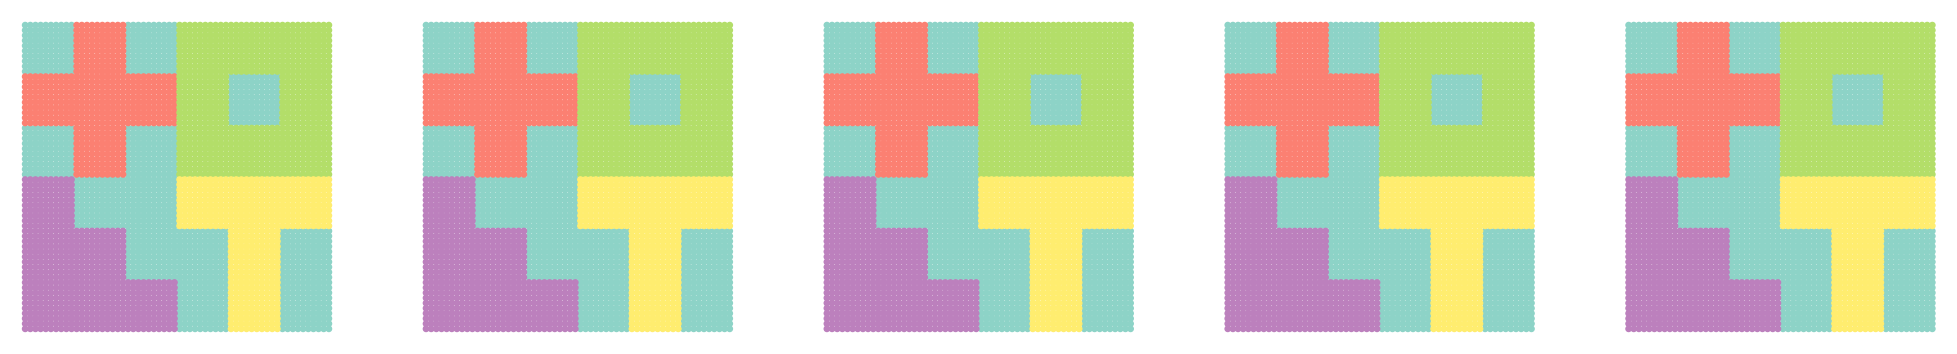

In [343]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*4
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

NCP: 100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


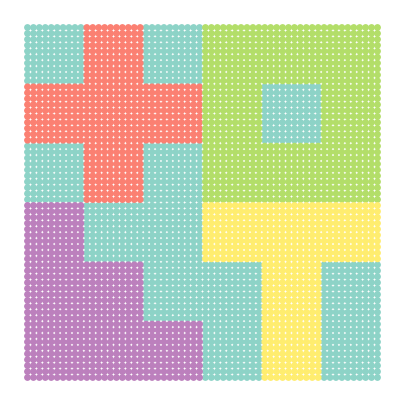

In [344]:
model = NCP()
topics = model.fit(X, y, n_steps=200)(z_features)
show_dataset(z_locations, topics)

NCP: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


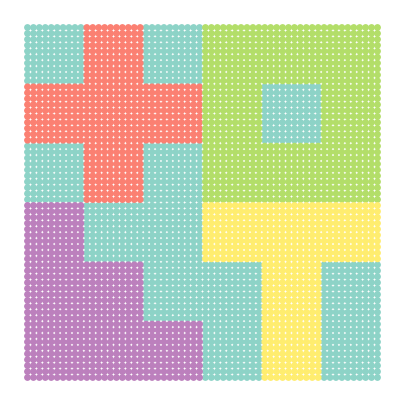

In [345]:
from ncp import NCP as oldNCP

model_old = oldNCP()
topics = model_old.fit(X, y)(z_features)
show_dataset(z_locations, topics)

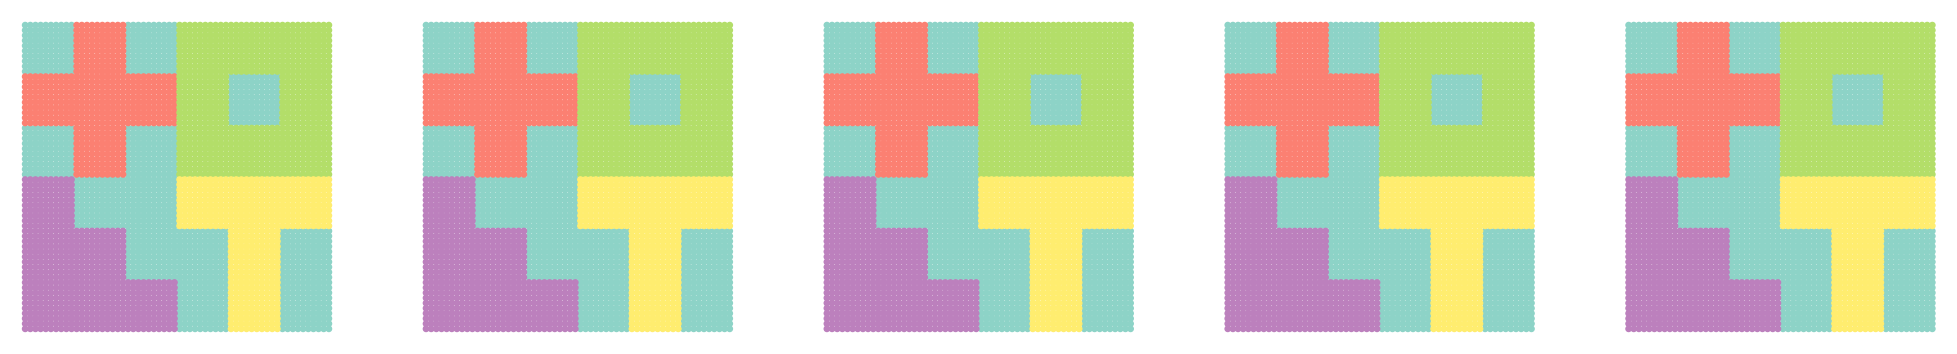

In [346]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*4
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

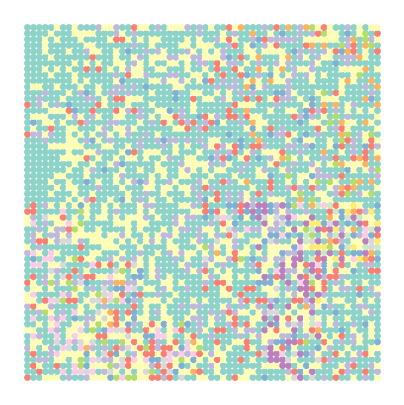

In [347]:
topics = model(z_features)
show_dataset(z_locations, topics)

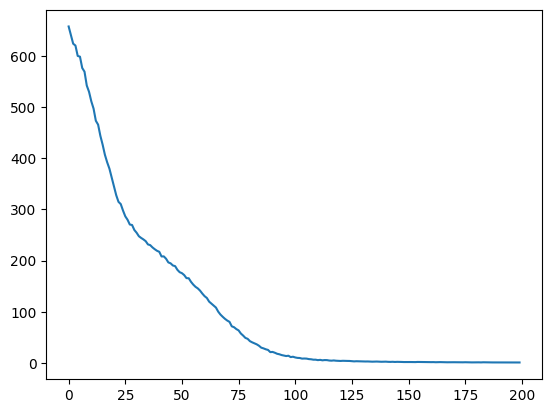

In [337]:
arr = np.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()

NCP: 100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


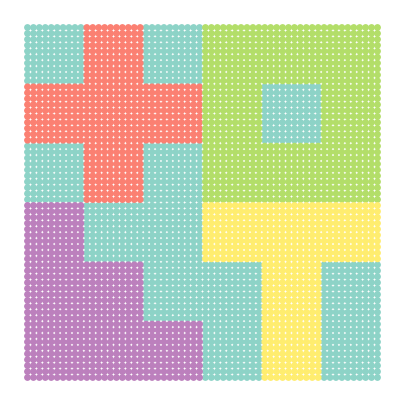

In [293]:
from ncp import NCP as oldNCP

model_old = oldNCP()
topics = model_old.fit(X, y)(z_features)
show_dataset(z_locations, topics)

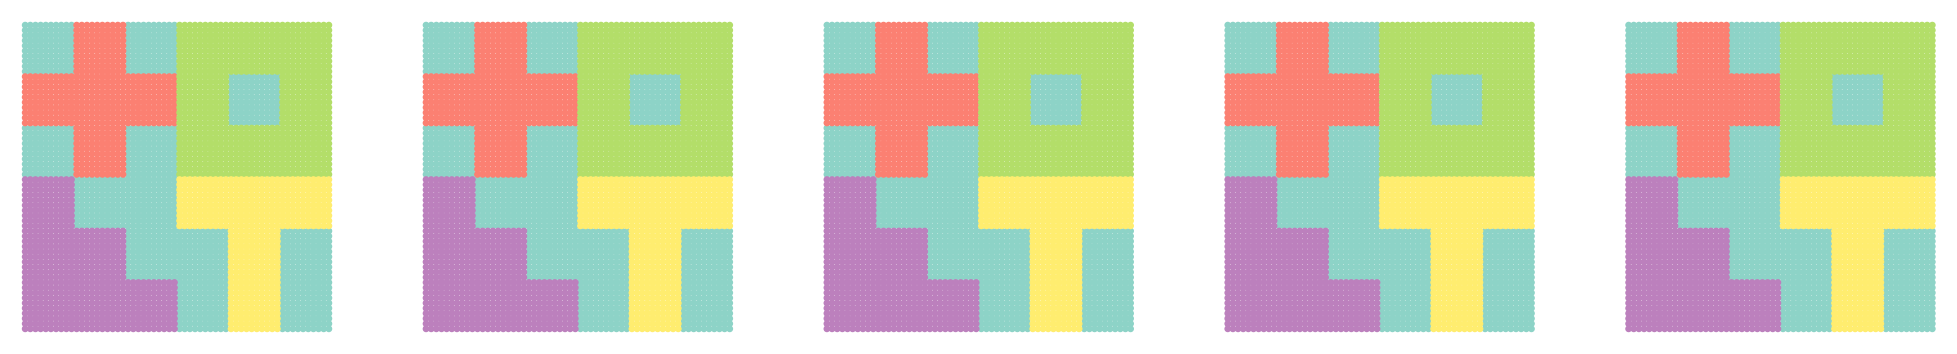

In [246]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*4
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

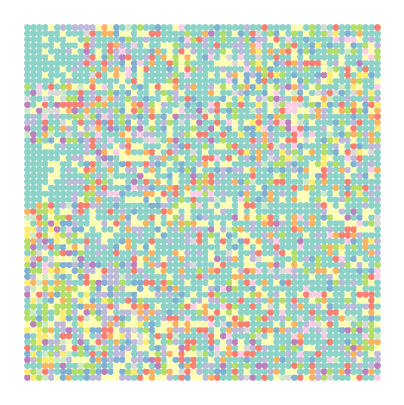

In [299]:
topics = model(z_features)
show_dataset(z_locations, topics)

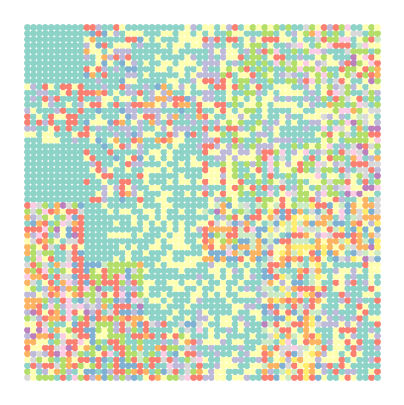

In [348]:
topics = model_old(z_features)
show_dataset(z_locations, topics)

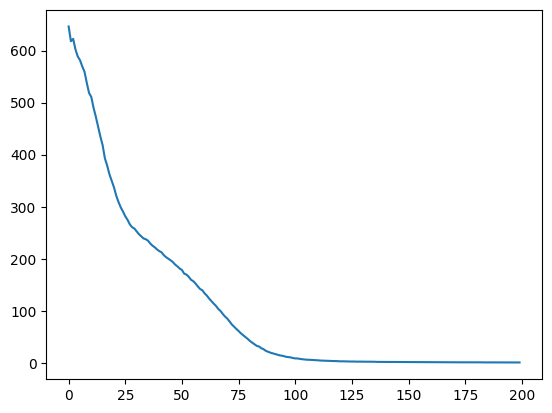

In [249]:
arr = np.arange(len(model_old.nll_log))
plt.plot(arr, model_old.nll_log)
plt.show()

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(GibbsLDA(3))

100%|██████████| 100/100 [00:00<00:00, 389.54it/s]


[{'estimator': GibbsLDA(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': GibbsLDA(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Chec